# Stable oxaria2 gases recalc
This notebook recasts the stable Oxaria2 gases sensor dataset following the dashboard showing issues in the Said BUsiness School timeseries. Investigation showed that the original 551 sensor stopped functioning in ~ 12/3/2021. It seems a filter was in place to handle this in the table below. The spare 558 sesnor was deployed to SBS on 21/4/21 as replacement. A filter needs to be established to limit 558 data to after this start date.

In [8]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
from datetime import timezone

register_matplotlib_converters()

# File locations
#----------------
the_gases = './oxaria/data/raw/2oxaria/json/gap_filling/batch_2_feb21_may21/'
pngs = './oxaria/data/pngs/gap_filling/'

In [9]:
# Load the df 
#-------------
oxaria2_gases_lt = pd.read_feather(the_gases+'oxaria2_gases_q12021_gf.ftr').set_index(['tag','rec'])


In [10]:
# Some cleaning incase have missed anything
#-------------------------------------------
oxaria2_gases_lt = oxaria2_gases_lt[~oxaria2_gases_lt.index.duplicated(keep='last')]
oxaria2_gases_lt = oxaria2_gases_lt.reset_index()
oxaria2_gases_lt = oxaria2_gases_lt.dropna(axis=0,subset=['tag']).set_index(['tag','rec'])
oxaria2_gases_lt.sort_index()
oxaria2_gases_lt.head()


val.no2.wev  val.no2.cnc  val.no2.aev  \
tag         rec                                                                
scs-bgx-550 2021-01-01 00:00:02+00:00      0.29150    45.099998      0.28944   
            2021-01-01 00:00:12+00:00      0.29138    44.500000      0.28944   
            2021-01-01 00:00:22+00:00      0.29132    44.200001      0.28944   
            2021-01-01 00:00:32+00:00      0.29138    44.500000      0.28944   
            2021-01-01 00:00:42+00:00      0.29125    44.000000      0.28944   

                                       val.no2.wec  val.sht.hmd  val.sht.tmp  \
tag         rec                                                                
scs-bgx-550 2021-01-01 00:00:02+00:00     -0.00184    83.900002          0.1   
            2021-01-01 00:00:12+00:00     -0.00197    83.900002          0.1   
            2021-01-01 00:00:22+00:00     -0.00203    83.900002          0.1   
            2021-01-01 00:00:32+00:00     -0.00197    83.900002          0.1   
            2021-01-01 00:00:42+00:00     -0.00209    83.800003          0.1   

                                       exg.vb20.no2.cnc              name  
tag         rec                                                            
scs-bgx-550 2021-01-01 00:00:02+00:00               NaN  Windhmill School  
            2021-01-01 00:00:12+00:00               NaN  Windhmill School  
            2021-01-01 00:00:22+00:00               NaN  Windhmill School  
            2021-01-01 00:00:32+00:00               NaN  Windhmill School  
            2021-01-01 00:00:42+00:00               NaN  Windhmill School

In [11]:
# Get a list of unique tags
#---------------------------
names = oxaria2_gases_lt['name'].unique()
names


array(['Windhmill School', 'Said Business School', 'County Hall',
       'Divinity Road', 'Jahlul Bayt Mosque', 'Windmill School2',
       'St Giles', 'Warneford Hospital', 'Spare', 'Speedwell St'],
      dtype=object)

In [12]:
# Get a list of unique tags
#---------------------------
tags = oxaria2_gases_lt.index.get_level_values(0).unique()
tags


Index(['scs-bgx-550', 'scs-bgx-551', 'scs-bgx-552', 'scs-bgx-553',
       'scs-bgx-554', 'scs-bgx-555', 'scs-bgx-556', 'scs-bgx-557',
       'scs-bgx-558', 'scs-bgx-559'],
      dtype='object', name='tag')

# Start and end dates of unstable operational periods

Have decided not to apply these as OPC do not seem to have start up problems in the same way as electrochems & applying them risks missing an event see 542 in earlt Feb below.


| Sensor tag  | Start               | End                 |
|-------------|---------------------|---------------------|
| scs-bgx-538 | 2021-01-28T00:00:00 | 2021-05-06T00:00:00 |
| scs-bgx-542 | 2021-01-27T12:00:00 | 2021-02-06T23:00:00 |
| scs-bgx-542 | 2021-04-19T09:00:00 | 2021-04-26T00:00:00 |
| scs-bgx-550 | 2021-03-10T12:00:00 | 2021-07-05T00:00:00 |
| scs-bgx-551 | 2021-01-01T00:00:00 | 2021-03-12T00:00:00 |
| scs-bgx-556 | 2021-02-09T12:00:00 | 2021-02-12T23:00:00 |
| scs-bgx-558 | 2021-04-21T12:00:00 | - |

21/4/21 1200 hours add as a start filter for 558 at SBS, only ata after this date to make it through to baseline adjustment etc.

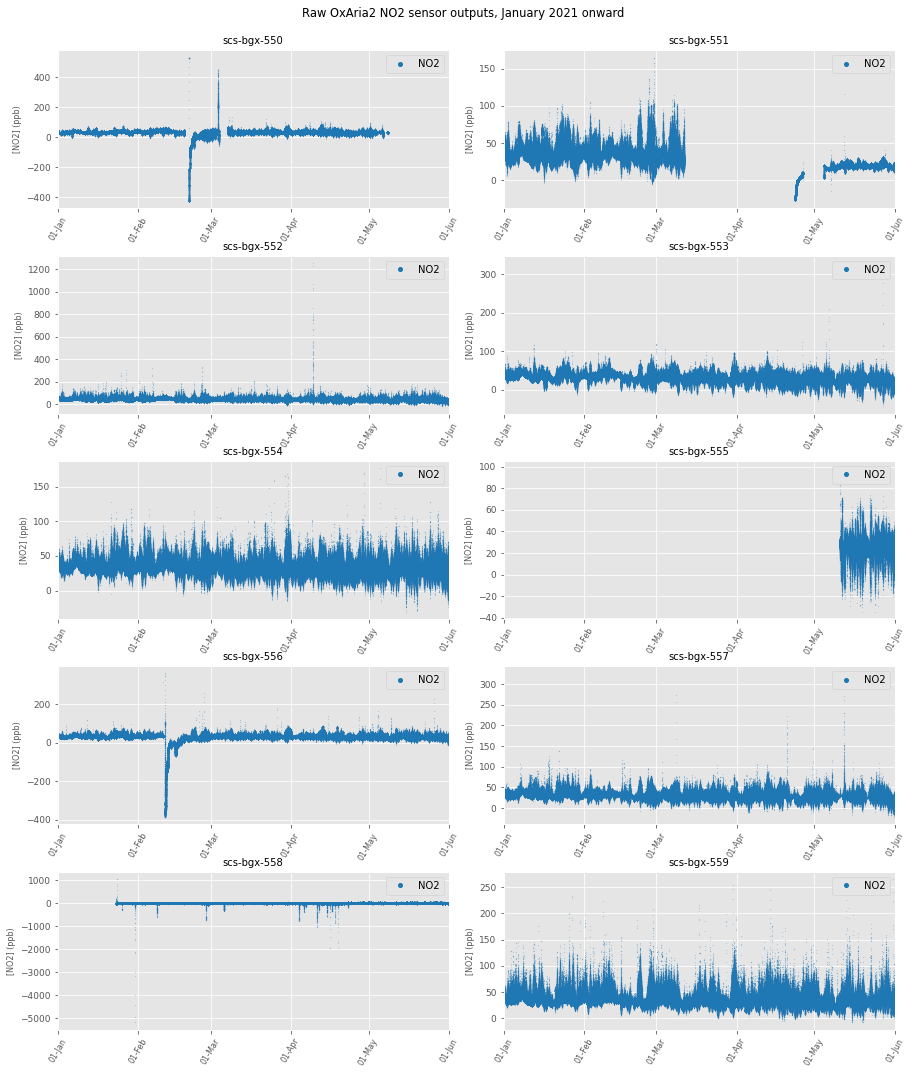

In [13]:
# Check on the outliers & start-ups in the original dataset
# ----------------------------------------------------------
plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date=dt.datetime(2021,1,1)
end_date=dt.datetime(2021,6,1)

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=False, sharey=False, figsize=(15,20))
axes_list = [item for sublist in axes for item in sublist] 

fig.suptitle('Raw OxAria2 NO2 sensor outputs, January 2021 onward', fontsize=11.5, y=0.91)

for tag, dat in oxaria2_gases_lt.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0,inplace=True)
    dat.plot(y='val.no2.cnc', c='tab:blue',linewidth=0.5, marker='o', ms=0.1, ls='', label='NO2', ax=ax, legend=True, \
            zorder=1)
    ax.set_title(tag, fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=60,
        labelsize=8
        )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.3)
    ax.legend(markerscale=40, frameon=True, framealpha=0.99, loc='upper right') 
    
plt.show()    
    
for ax in axes_list:
    ax.remove()

In [14]:
# Manually select each sensor with an issue then subset to remove the wonky data
#--------------------------------------------------------------------------------
s550 = oxaria2_gases_lt.reset_index().query('tag == "scs-bgx-550"').query(
    'rec <= "2021-02-20T12:00:00+0000" | rec > "2021-02-25T00:00:00+0000"')
s550 = s550.query('tag == "scs-bgx-550"').query(
    'rec <= "2021-03-03T12:00:00+0000" | rec > "2021-03-05T00:00:00+0000"')
s551 = oxaria2_gases_lt.reset_index().query('tag == "scs-bgx-551"').query(
    'rec <= "2021-03-12T00:00:00+0000" | rec > "2021-05-05T00:00:00+0000"')
s556 = oxaria2_gases_lt.reset_index().query('tag == "scs-bgx-556"').query(
    'rec <= "2021-02-09T12:00:00+0000" | rec > "2021-02-20T23:00:00+0000"')
s558 = oxaria2_gases_lt.reset_index().query('tag == "scs-bgx-558"').query(
    'rec > "2021-04-21T12:00:00+0000"')

# Sensors with no issues
#------------------------
ok_tags = [
    'scs-bgx-552', 'scs-bgx-553', 'scs-bgx-554', 'scs-bgx-555', 'scs-bgx-557',
    'scs-bgx-559'
]

# Select the sensor records with tags in this list
#--------------------------------------------------
sother = oxaria2_gases_lt.reset_index().query('tag in @ok_tags')

# Recombine
#-----------
oxaria2_gases_lt1 = pd.concat([sother,s550,s551,s556,s558]).set_index(['tag','rec'])

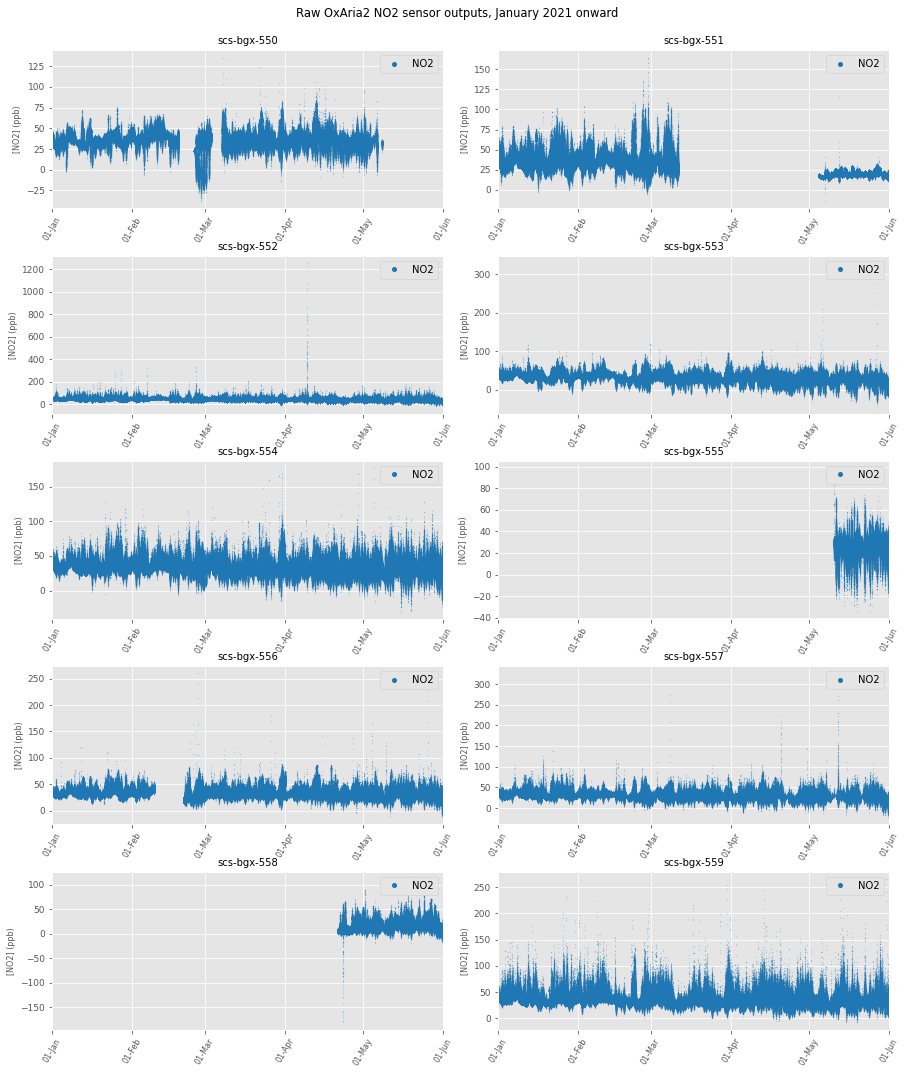

In [15]:
# Check on the outliers & start-ups in the filtered dataset
# ----------------------------------------------------------
plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date=dt.datetime(2021,1,1)
end_date=dt.datetime(2021,6,1)

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=False, sharey=False, figsize=(15,20))
axes_list = [item for sublist in axes for item in sublist] 

fig.suptitle('Raw OxAria2 NO2 sensor outputs, January 2021 onward', fontsize=11.5, y=0.91)

for tag, dat in oxaria2_gases_lt1.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0,inplace=True)
    dat.plot(y='val.no2.cnc', c='tab:blue',linewidth=0.5, marker='o', ms=0.1, ls='', label='NO2', ax=ax, legend=True, \
            zorder=1)

    ax.set_title(tag, fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=60,
        labelsize=8
        )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(28))
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.3)
    ax.legend(markerscale=40, frameon=True, framealpha=0.99, loc='upper right') 
    
plt.show()    
    
for ax in axes_list:
    ax.remove()


In [16]:
# Apply empirical filters
#-------------------------
cols = ['val.no2.cnc']

condition =  ((oxaria2_gases_lt1['val.sht.tmp'] < -10.0) | \
             (oxaria2_gases_lt1['val.sht.tmp'] > 35.0) | \
             (oxaria2_gases_lt1['val.sht.hmd'] < 35.0))

for col in cols:
    oxaria2_gases_lt1[col+'_1'] = np.where(condition, np.nan, oxaria2_gases_lt1[col])

    
# Save to feather
#-----------------
oxaria2_gases_lt1.reset_index().to_feather(the_gases+'oxaria2_gases_stable_536_q12021_v2.ftr')
